<a href="https://colab.research.google.com/github/ritabandutta13/CE888/blob/main/Lab_3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV


First we will load the data into the notebook the data is saved on the personal repository.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/hamzajb95/CE888/master/Lab3/bank-additional-full.txt", delimiter = ";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# Data Preprocessing

In [ ]:
#First we will apply LabelEncoding on all categorical features
#But first I want to check number of unique values in each feature.
for col in df.columns:
  print(col,"--> ",len(df[col].unique()))


age -->  78
job -->  12
marital -->  4
education -->  8
default -->  3
housing -->  3
loan -->  3
contact -->  2
month -->  10
day_of_week -->  5
duration -->  1544
campaign -->  42
pdays -->  27
previous -->  8
poutcome -->  3
emp.var.rate -->  10
cons.price.idx -->  26
cons.conf.idx -->  26
euribor3m -->  316
nr.employed -->  11
y -->  2


In [ ]:
#applying Label Encoder to the Label
df2 = df.copy()
le = preprocessing.LabelEncoder()
le.fit(df2['y'].unique())
df2['y'] = le.transform(df2['y'])
df2

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [ ]:
#Convert to One-Hot Encoding using pd.get_dummies
df_dummies = pd.get_dummies(df2)

# Then we remove the 'duration' column as instructed
df_dummies.drop(columns=['duration'],inplace=True)
df_dummies

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [ ]:
#Now we check for missing values
print(df_dummies.isna().any())
print("True if there are mising values -> ",df_dummies.isna().any().any())
#We conclude no missing values
#True if there are mising values ->  False

age                     False
campaign                False
pdays                   False
previous                False
emp.var.rate            False
                        ...  
day_of_week_tue         False
day_of_week_wed         False
poutcome_failure        False
poutcome_nonexistent    False
poutcome_success        False
Length: 63, dtype: bool
True if there are mising values ->  False


y=0 for  88.73 % of total observations
y=1 has 11.27 %  of total observations


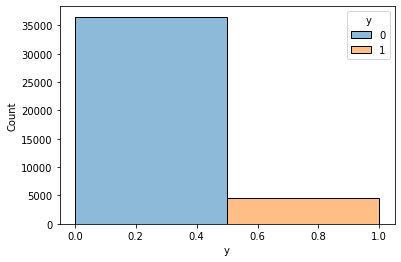

In [ ]:
dataset = df_dummies.groupby('y').count()
dataset
y0Count = dataset.iloc[0][1]
y1Count = dataset.iloc[1][1]
total = len(df_dummies)
print('y=0 for ',round((y0Count/total)*100,2),"% of total observations")
print("y=1 has",round((y1Count/total)*100,2),"%  of total observations")


g = sns.histplot(data=df_dummies, x="y", bins=2, hue="y")

In [ ]:
#We will split our training and testing data.
X_train, X_test, y_train, y_test = train_test_split(df_dummies.loc[:,df_dummies.columns!='y'],df_dummies['y'],test_size=0.2,random_state=50, stratify=df_dummies['y'])
#checking for stratification
yCounts_train = np.bincount(y_train)
yCounts_test = np.bincount(y_test)
Ntrain = len(y_train)
Ntest = len(y_test)

print(yCounts_train, yCounts_test)
print("In the train set",round(yCounts_train[0]/Ntrain,2), "% are y=0 and ",round(yCounts_train[1]/Ntrain,2),"% are y=1")
print("In the train set",round(yCounts_test[0]/Ntest,2), "% are y=0 and ",round(yCounts_test[1]/Ntest,2),"% are y=1")


[29238  3712] [7310  928]
In the train set 0.89 % are y=0 and  0.11 % are y=1
In the train set 0.89 % are y=0 and  0.11 % are y=1


With checking the number of observations for each class in both training and testing data, we are able to confirm that a stratified split was made.<br>
Now we will make a Random Forest Classifier. 

In [ ]:
myClf = RandomForestClassifier(max_depth=3, n_estimators=100)
skf = StratifiedKFold(n_splits=10)
RFresults = cross_val_score(myClf, X_train, y_train, cv=skf, scoring='accuracy')
RFresults.mean()

0.898330804248862

In [ ]:
dummyClf = DummyClassifier(strategy="stratified")
dumResults = cross_val_score(dummyClf, X_train, y_train, cv=10, scoring="accuracy")
dumResults.mean()

0.802154779969651

After comparing the mean of the cross-validated accuracies, we can conclude that the the Random Forest Classifier is 9% more accurate.

Now we are going to use GridSearchCV to perform hyperparameter tuning using GridSearchCV

In [ ]:
#Lets set the grid for the hyperparameters
## Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=7)]
#number of features to consider every split
max_features = ['auto','sqrt']
#Max num of levels in tree
max_depth = [2,4]
#Minimum number of samples required at each leaf node for split
min_samples_split = [2,5]
#Min number of samples required at each leaf node.
min_samples_leaf = [1,2]
#
bootstrap = [True,False]

myParam_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap}

print(myParam_grid)

{'n_estimators': [10, 41, 73, 105, 136, 168, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
#Create Vanilla flavoured Random Forest Classifer
newClfRF = RandomForestClassifier()
#set it as the estimator and provide parameter grid 
rf_Grid = GridSearchCV(estimator=newClfRF, param_grid=myParam_grid, cv=3,verbose=2,n_jobs=4)
# Get the Grid fitted on the training set to determine which parameters are the best
rf_Grid.fit(X_train, y_train)


Fitting 3 folds for each of 224 candidates, totalling 672 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done 672 out of 672 | elapsed:  8.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
#Print out the best hyper-parameters from the possible hyper-parameters
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [ ]:
print('Train Accuracy - :', rf_Grid.score(X_train,y_train))
print(f'Test Accuracy - :', rf_Grid.score(X_test,y_test))

Train Accuracy - : 0.8993626707132019
Test Accuracy - : 0.9005826656955572


Now that we have the best parameters we can create a new Random Forest Classifier and apply Cross-Validation

In [ ]:
newRfClf = RandomForestClassifier(max_depth=4, n_estimators=10, max_features='auto', min_samples_leaf=1, min_samples_split=5, bootstrap=False)
skf2 = StratifiedKFold(n_splits=10)
newRFresults = cross_val_score(myClf, X_train, y_train, cv=skf2, scoring='accuracy')
newRFresults

array([0.89499241, 0.9016692 , 0.89711684, 0.90045524, 0.89286798,
       0.90440061, 0.90713202, 0.89681335, 0.89772382, 0.89650986])

In [ ]:
newRfClf.fit(X_test,y_test)
importance = newRfClf.feature_importances_
for feature,score in enumerate(importance):
  print("Feature:", feature," Score:",score)

Feature: 0  Score: 0.02114806477270053
Feature: 1  Score: 0.005750943508144446
Feature: 2  Score: 0.11630559930250069
Feature: 3  Score: 0.015031817164555308
Feature: 4  Score: 0.10593340701545792
Feature: 5  Score: 0.09567845468810673
Feature: 6  Score: 0.13567793813385323
Feature: 7  Score: 0.1210336616150333
Feature: 8  Score: 0.1566874119115861
Feature: 9  Score: 0.001323301948062684
Feature: 10  Score: 0.0055309154393603085
Feature: 11  Score: 0.0
Feature: 12  Score: 0.0002592384273312872
Feature: 13  Score: 0.0
Feature: 14  Score: 0.0011607083806221645
Feature: 15  Score: 0.0
Feature: 16  Score: 0.0006194176471043046
Feature: 17  Score: 0.010873623407869858
Feature: 18  Score: 0.0003956522923549015
Feature: 19  Score: 0.0
Feature: 20  Score: 0.0
Feature: 21  Score: 0.0003602679764974527
Feature: 22  Score: 0.0002680951528489509
Feature: 23  Score: 0.0015104095797875718
Feature: 24  Score: 0.000125850156739819
Feature: 25  Score: 0.00024782199363398814
Feature: 26  Score: 0.0
Feat

In [ ]:
df_dummies.iloc[:,[40]]

,loan_no
0,1
1,1
2,1
3,1
4,0
...,...
41183,1
41184,1
41185,1
41186,1


In [ ]:
#Things left to do:
# 1) What are the top 3 features? (Almost done)
# 2) Report the generalisation error (still using the same metric) on your test set.(To-do)